<a href="https://colab.research.google.com/github/olivierschirm/GPS-tracks-analysis-to-automatically-generate-hiking-paths-maps/blob/main/VR_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [2]:
def patchImage(img, size) :
  img = np.expand_dims(img, 0)
  img = np.expand_dims(img, 3)

  sizes = [1, size, size, 1]
  strides = [1, size, size, 1]
  rates = [1, 1, 1, 1] 
  padding = 'VALID'

  imgs = tf.image.extract_patches(
      np.array(img), sizes, strides, rates, padding, name=None
  )

  return imgs

def retriveImages(patches, size) : 
  images = []
  for line in patches[0] :
    for img in line :
      images.append(np.array(img).reshape((size, size)))

  return np.array(images)

In [3]:
data = Image.open('40 1.3.png').convert('L')
data = ImageOps.invert(data)
truth = Image.open('truthblavr.png').convert('L')
size = 200
split = 100

patchesExemples = patchImage(data, size)
patchesExemples = retriveImages(patchesExemples, size)
patchesExemples = patchesExemples / 255
patchesExemples = patchesExemples.reshape(patchesExemples.shape[0],patchesExemples.shape[1],patchesExemples.shape[2],1)

patchesTruth = patchImage(truth, size)
patchesTruth = retriveImages(patchesTruth, size)
patchesTruth = patchesTruth / 255
patchesTruth = patchesTruth.reshape(patchesTruth.shape[0],patchesTruth.shape[1],patchesTruth.shape[2],1)

patchesExemples, patchesTruth = zip(*tf.random.shuffle(list(zip(patchesExemples, patchesTruth))))

x_train = np.array(patchesExemples[0:split])
y_train = np.array(patchesTruth[0:split])
x_test = np.array(patchesExemples[split:])
y_test = np.array(patchesTruth[split:])

# plt.figure(figsize=(30,30))
# plt.subplot(1,2,1)
# plt.imshow(np.squeeze(x_test[0], axis=2), cmap="binary")
# plt.subplot(1,2,2)
# plt.imshow(np.squeeze(y_test[0], axis=2), cmap="binary")
# plt.show()

In [4]:
keras.backend.clear_session()

input_shape = x_train.shape[1:]

input_layer = keras.layers.Input(input_shape)

# couche de convolution
conv_1 = keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                            activation='relu',padding='same')(input_layer)

# output 
output_layer = keras.layers.Conv2D(filters=1, kernel_size=(3,3),
                            activation='relu',padding='same')(conv_1)

# construire le modèle 
model = keras.models.Model(inputs=input_layer,outputs=output_layer)

# afficher le modèle 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 1)       577       
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [73]:
# choisir la fonction de coût 
cost_function = keras.losses.mse 

# choisir l'algo d'optim 
optimizer_algo = keras.optimizers.Adam()

# compiler le modèle 
model.compile(loss=cost_function,optimizer=optimizer_algo, 
              metrics=['accuracy'])

# lancer l'entrainement 
history = model.fit(x_train, y_train, batch_size=20, epochs=10, 
          verbose=0, validation_split=0.1)

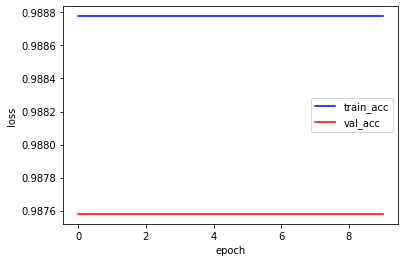

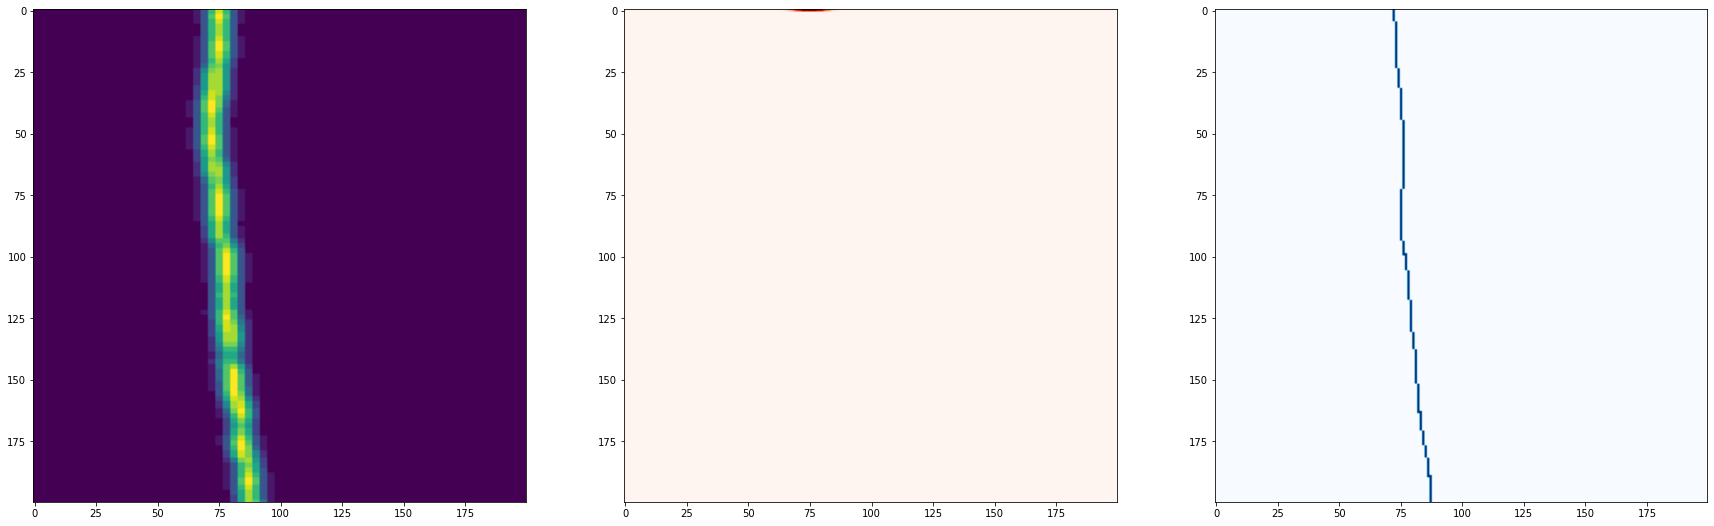

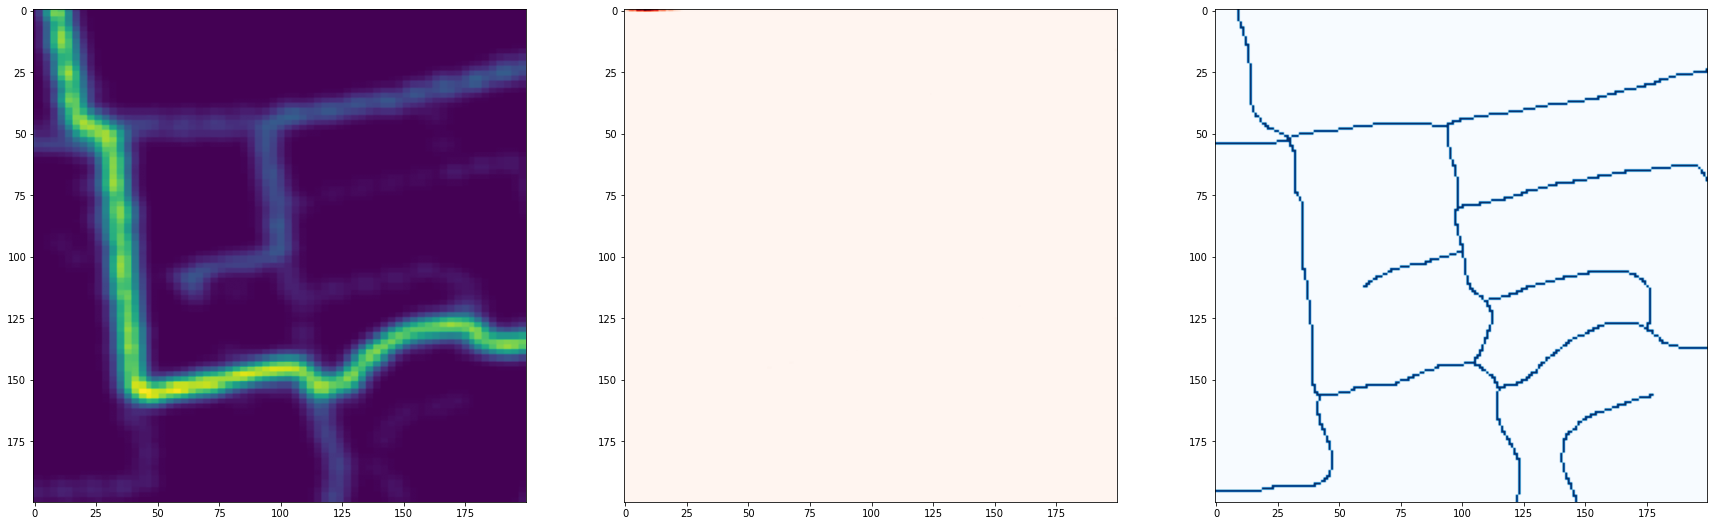

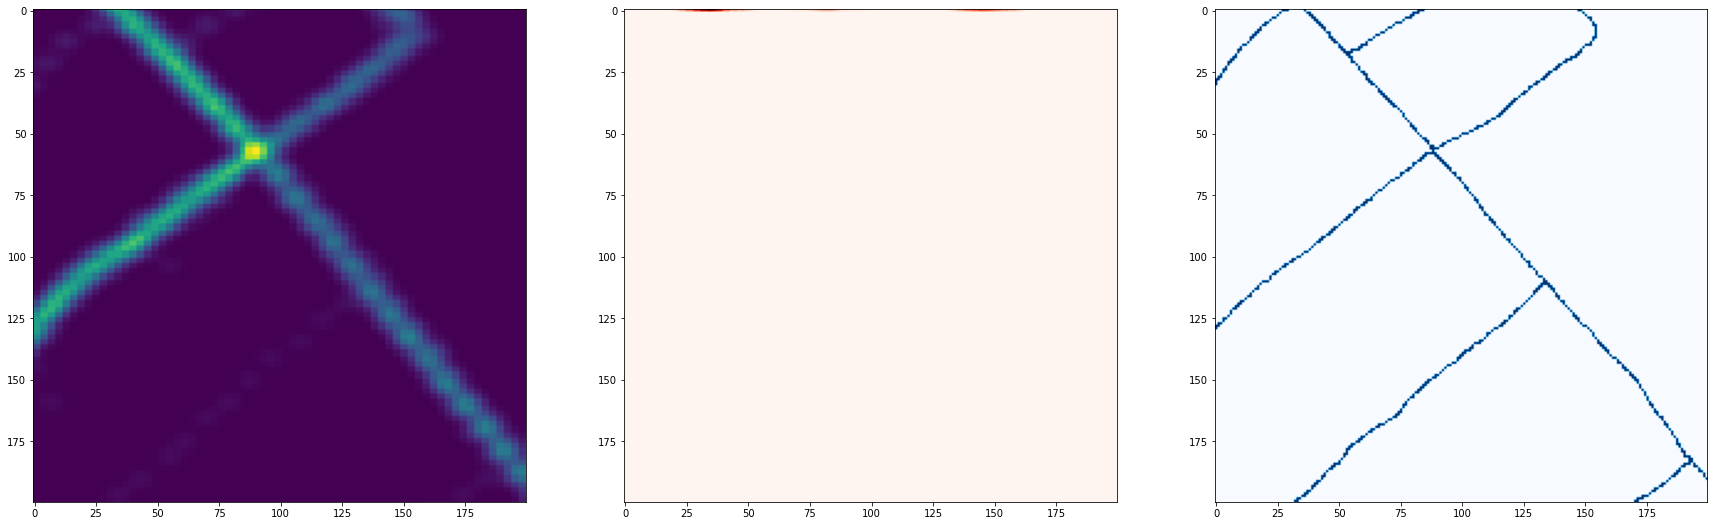

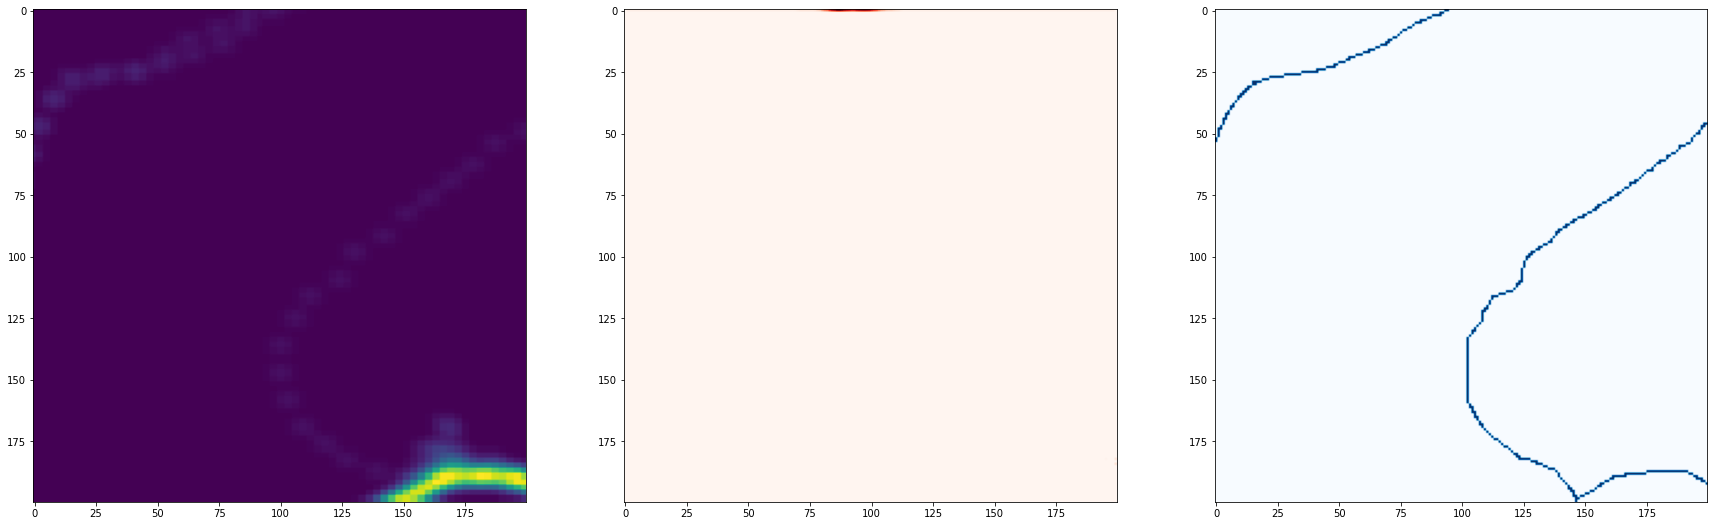

In [74]:
imgs = model.predict(x_test)

history_dict = history.history
loss_train_epochs = history_dict['accuracy']
loss_val_epochs = history_dict['val_accuracy']

plt.figure()
plt.plot(loss_train_epochs,color='blue',label='train_acc')
plt.plot(loss_val_epochs,color='red',label='val_acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('epoch-loss.pdf')
plt.show()
plt.close()


for i in range(0, 4) :
  im1 = np.squeeze(x_test[i], axis=2)
  im2 = np.squeeze(imgs[i], axis=2)
  im3 = np.squeeze(y_test[i], axis=2)

  plt.figure(figsize=(30,30))
  plt.subplot(1,3,1)
  plt.imshow(im1)
  plt.subplot(1,3,2)
  plt.imshow(im2, cmap="Reds")
  plt.subplot(1,3,3)
  plt.imshow(im3, cmap="Blues")
  plt.show()